In [557]:
from stasis_jax import Simulator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import glob
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.metrics import r2_score

In [36]:
import numpy as np
import glob

# Define the path to the directory containing the arrays
PATH = '/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results'

# Get the list of omega and gamma files
omega_files = glob.glob(f'{PATH}/omega_vals_gradient_ascent_pl_*.npy')
gamma_files = glob.glob(f'{PATH}/gamma_vals_gradient_ascent_pl_*.npy')

def clean_and_transform_gamma(array):
    # Remove steps with NaNs
    cleaned_array = array[~np.isnan(array).any(axis=1)]
    # Raise each value by 10**value
    transformed_array = 10 ** cleaned_array
    return transformed_array

def clean_and_transform_omega(array):
    # Remove steps with NaNs
    cleaned_array = array[~np.isnan(array).any(axis=1)]
    # Raise each value by 10**value
    transformed_array = 10 ** cleaned_array
    normalized_array = transformed_array / np.sum(transformed_array, axis=1)[:, None]
    
    return normalized_array

# Process omega files
for omega_file in omega_files:
    omega_array = np.load(omega_file)
    cleaned_transformed_omega = clean_and_transform_omega(omega_array)
    np.save(omega_file, cleaned_transformed_omega)

# Process gamma files
for gamma_file in gamma_files:
    gamma_array = np.load(gamma_file)
    cleaned_transformed_gamma = clean_and_transform_gamma(gamma_array)
    np.save(gamma_file, cleaned_transformed_gamma)

print("Cleaning and transformation completed.")


Cleaning and transformation completed.


In [95]:
# Define the path to the directory containing the arrays
PATH = '/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results'
# SAVE_PATH = '/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/power_law_results'

# if not os.path.exists(SAVE_PATH):
#     os.makedirs(SAVE_PATH)
    
# Get the list of omega and gamma files
omega_files = sorted(glob.glob(f'{PATH}/omega_vals_gradient_ascent_uniform_*.npy'))
gamma_files = sorted(glob.glob(f'{PATH}/gamma_vals_gradient_ascent_uniform_*.npy'))

def run_simulation(omega_array, gamma_array):
    sim = Simulator(Omega_0=omega_array, Gamma_0=gamma_array)
    stasis_val, asymptote_val = sim.return_stasis()
    return stasis_val, asymptote_val

In [111]:
def fit_exponential(x, y):
    def linear(x, a, b):
        return a * x + b

    popt, _ = curve_fit(linear, x, np.log(y), p0=(1, 0.1), maxfev=10000)
    y_exp_fit = linear(x, *popt)
    mse = np.mean((np.log(y) - y_exp_fit) ** 2)
    # weights = 1 / (y + 1e-10)
    # mse = np.average((np.log(y) - y_exp_fit) ** 2, weights=weights)
    norm_mse = mse / np.mean(np.log(y) ** 2)
    mape = np.mean(np.abs((np.log(y) - y_exp_fit) / np.log(y + 1e-10))) * 100
    r2 = r2_score(np.log(y), y_exp_fit)
    return mape, r2

def fit_power_law(x, y):
    def linear(x, a, b):
        return a * x + b
    popt, _ = curve_fit(linear, np.log(x), np.log(y), p0=(1, 1), maxfev=10000)
    y_pow_fit = linear(np.log(x), *popt)
    mse = np.mean((np.log(y) - y_pow_fit) ** 2)
    norm_mse = mse / np.mean(np.log(y) ** 2)
    mape = np.mean(np.abs((np.log(y) - y_pow_fit) / np.log(y + 1e-10))) * 100   
    r2 = r2_score(np.log(y), y_pow_fit)
    return mape, r2

def return_mses(ell, y, mode='first', end_idx = 50):
    if mode == 'first':
        mse_pl, r2_pl = fit_power_law(ell[1:49], y[1:49])
        mse_exp, r2_exp = fit_exponential(ell[1:49], y[1:49])
        
    elif mode == 'last':
        y = y[3:end_idx]
        x = np.linspace(1, y.size, y.size)
        mse_pl, r2_pl = fit_power_law(x, y)
        mse_exp, r2_exp = fit_exponential(x, y)
        
    return mse_pl, mse_exp, r2_pl, r2_exp

def find_end_idx(array):
    differences = np.abs(np.diff(array))
    discontinuity_index = np.argmax(differences)
    return discontinuity_index

def find_end_idx(array):
    differences = np.abs(np.diff(array))
    # Get the indices of the sorted differences in descending order
    sorted_indices = np.argsort(differences)[::-1]
    # Get the first and second largest indices
    first_largest_index = sorted_indices[0]
    second_largest_index = sorted_indices[1]
    # Return the one with the lowest index
    return min(first_largest_index, second_largest_index)


In [309]:

def process_file(omega_file, gamma_file, idx):
    # Load the arrays
    omega_array = np.load(omega_file)
    gamma_array = np.load(gamma_file)
    
    mask_idxs = [0,-1]
    first_last_omega = omega_array[mask_idxs]
    first_last_gamma = gamma_array[mask_idxs]
    
    # Run simulations in parallel
    results = Parallel(n_jobs=-1)(delayed(run_simulation)(omega_step, gamma_step) 
                                  for omega_step, gamma_step in tqdm(zip(first_last_omega, first_last_gamma)))
    
    vals, asymptotes = zip(*results)
    
    epoch_0_stasis_val, epoch_0_asymptote = vals[0], asymptotes[0]
    epoch_end_stasis_val, epoch_end_asymptote = vals[1], asymptotes[1]
    
    return epoch_0_stasis_val, epoch_end_stasis_val, epoch_0_asymptote, epoch_end_asymptote
    
all_epoch_0_stasis_vals = []
all_epoch_end_stasis_vals = []
all_epoch_0_asymptotes = []
all_epoch_end_asymptotes = []
for idx, (omega_file, gamma_file) in tqdm(enumerate(zip(omega_files, gamma_files))):
    epoch_0_stasis_val, epoch_end_stasis_val, epoch_0_asymptote, epoch_end_asymptote = process_file(omega_file, gamma_file, idx)
    all_epoch_0_stasis_vals.append(epoch_0_stasis_val)
    all_epoch_end_stasis_vals.append(epoch_end_stasis_val)
    all_epoch_0_asymptotes.append(epoch_0_asymptote)
    all_epoch_end_asymptotes.append(epoch_end_asymptote)

print("Simulation completed and results saved.")

np.save(f'{SAVE_PATH}/stasis_vals_epoch_0.npy', np.array(all_epoch_0_stasis_vals))
np.save(f'{SAVE_PATH}/stasis_vals_epoch_end.npy', np.array(all_epoch_end_stasis_vals))
np.save(f'{SAVE_PATH}/asymptotes_epoch_0.npy', np.array(all_epoch_0_asymptotes))
np.save(f'{SAVE_PATH}/asymptotes_epoch_end.npy', np.array(all_epoch_end_asymptotes))

2it [00:00, 2933.08it/s]
I0000 00:00:1719858452.171356       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1719858452.171365       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2it [00:00, 3033.85it/s]
I0000 00:00:1719858454.543421       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2it [00:00, 3496.71it/s]
I0000 00:00:1719858456.665537       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2it [00:00, 2684.35it/s]
I0000 00:00:1719858458.891340       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2it [00:00, 3013.15it/s]
I0000 00:00:1719858461.077209       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1719858461.078933       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2it [00:00, 6820.01it/s]
I0000 00:00:1719858463.635415       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2it [00:00, 541.86it/s]
2it [00:00, 1669.37it/s]
2it [00:00, 5629.94it/s]
2it [00:00, 4524.60it/s]
I0000 00:00:1719858469.450051  

Simulation completed and results saved.


In [112]:
def mse_parallel(omega_file, gamma_file, idx):
    # Load the arrays
    omega_array = np.load(omega_file)
    gamma_array = np.load(gamma_file)
    
    index = omega_file.split('_')[-1].split('.')[0]
    
    first_omega = omega_array[0]
    last_omega = omega_array[-1]
    first_gamma = gamma_array[0]
    last_gamma = gamma_array[-1]
    
    end_idx_omega = find_end_idx(last_omega)
    end_idx_gamma = find_end_idx(last_gamma)
    
    # Run simulations in parallel
    ell = np.linspace(1, omega_array.shape[1], omega_array.shape[1])
    gamma_mse_pl_epoch_0, gamma_mse_exp_epoch_0, gamma_r2_pl_epoch_0, gamma_r2_mse_epoch_0 = return_mses(ell, first_gamma, mode='first')
    gamma_mse_pl_epoch_end, gamma_mse_exp_epoch_end, gamma_r2_pl_epoch_end, gamma_r2_mse_epoch_end = return_mses(ell, last_gamma, mode='last', end_idx=end_idx_gamma)
    omega_mse_pl_epoch_0, omega_mse_exp_epoch_0, omega_r2_pl_epoch_0, omega_r2_mse_epoch_0 = return_mses(ell, first_omega, mode='first')
    omega_mse_pl_epoch_end, omega_mse_exp_epoch_end, omega_r2_pl_epoch_end, omega_r2_mse_epoch_end = return_mses(ell, last_omega, mode='last', end_idx=end_idx_omega)
    
    
    return gamma_mse_pl_epoch_0, gamma_mse_exp_epoch_0, gamma_r2_pl_epoch_0, gamma_r2_mse_epoch_0, gamma_mse_pl_epoch_end, gamma_mse_exp_epoch_end, gamma_r2_pl_epoch_end, gamma_r2_mse_epoch_end, omega_mse_pl_epoch_0, omega_mse_exp_epoch_0, omega_r2_pl_epoch_0, omega_r2_mse_epoch_0, omega_mse_pl_epoch_end, omega_mse_exp_epoch_end, omega_r2_pl_epoch_end, omega_r2_mse_epoch_end, index
    
    
results_dict = {'epoch_0': {'gamma': {'pl': [], 'exp': [], 'r2_pl': [], 'r2_exp': []}, 'omega': {'pl': [], 'exp': [],  'r2_pl': [], 'r2_exp': []}},
                'epoch_end': {'gamma': {'pl': [], 'exp': [], 'r2_pl': [], 'r2_exp': []}, 'omega': {'pl': [], 'exp': [],  'r2_pl': [], 'r2_exp': []}},
                'idx': [],
                'begin_stasis_vals': [],
                'end_stasis_vals': []}

# Process each pair of omega and gamma files
for idx, (omega_file, gamma_file) in tqdm(enumerate(zip(omega_files, gamma_files))):
    try:
        gamma_mse_pl_epoch_0, gamma_mse_exp_epoch_0, gamma_r2_pl_epoch_0, gamma_r2_mse_epoch_0, gamma_mse_pl_epoch_end, gamma_mse_exp_epoch_end, gamma_r2_pl_epoch_end, gamma_r2_mse_epoch_end, omega_mse_pl_epoch_0, omega_mse_exp_epoch_0, omega_r2_pl_epoch_0, omega_r2_mse_epoch_0, omega_mse_pl_epoch_end, omega_mse_exp_epoch_end, omega_r2_pl_epoch_end, omega_r2_mse_epoch_end, index = mse_parallel(omega_file, gamma_file, idx)
    except:
        print(f"Error in file {omega_file}")
    results_dict['epoch_0']['gamma']['pl'].append(gamma_mse_pl_epoch_0)
    results_dict['epoch_0']['gamma']['exp'].append(gamma_mse_exp_epoch_0)
    results_dict['epoch_0']['gamma']['r2_pl'].append(gamma_r2_pl_epoch_0)
    results_dict['epoch_0']['gamma']['r2_exp'].append(gamma_r2_mse_epoch_0)
    results_dict['epoch_end']['gamma']['pl'].append(gamma_mse_pl_epoch_end)
    results_dict['epoch_end']['gamma']['exp'].append(gamma_mse_exp_epoch_end)
    results_dict['epoch_end']['gamma']['r2_pl'].append(gamma_r2_pl_epoch_end)
    results_dict['epoch_end']['gamma']['r2_exp'].append(gamma_r2_mse_epoch_end)
    results_dict['epoch_0']['omega']['pl'].append(omega_mse_pl_epoch_0)
    results_dict['epoch_0']['omega']['exp'].append(omega_mse_exp_epoch_0)
    results_dict['epoch_0']['omega']['r2_pl'].append(omega_r2_pl_epoch_0)
    results_dict['epoch_0']['omega']['r2_exp'].append(omega_r2_mse_epoch_0)
    results_dict['epoch_end']['omega']['pl'].append(omega_mse_pl_epoch_end)
    results_dict['epoch_end']['omega']['exp'].append(omega_mse_exp_epoch_end)
    results_dict['epoch_end']['omega']['r2_pl'].append(omega_r2_pl_epoch_end)
    results_dict['epoch_end']['omega']['r2_exp'].append(omega_r2_mse_epoch_end)
    results_dict['idx'].append(index)
    

print("Simulation completed and results saved.")

26it [00:00, 245.08it/s]/Users/snehpandya/venv-ml/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/snehpandya/venv-ml/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
50it [00:00, 235.19it/s]

Error in file /Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/omega_vals_gradient_ascent_uniform_27.npy
Simulation completed and results saved.


In [54]:
uniform_results_dict = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/mse_results.npy', allow_pickle=True).item()

In [55]:
uniform_results_dict['epoch_0']['gamma']['r2_pl'] = results_dict['epoch_0']['gamma']['r2_pl']
uniform_results_dict['epoch_0']['gamma']['r2_exp'] = results_dict['epoch_0']['gamma']['r2_exp']
uniform_results_dict['epoch_0']['omega']['r2_pl'] = results_dict['epoch_0']['omega']['r2_pl']
uniform_results_dict['epoch_0']['omega']['r2_exp'] = results_dict['epoch_0']['omega']['r2_exp']
uniform_results_dict['epoch_end']['gamma']['r2_pl'] = results_dict['epoch_end']['gamma']['r2_pl']
uniform_results_dict['epoch_end']['gamma']['r2_exp'] = results_dict['epoch_end']['gamma']['r2_exp']
uniform_results_dict['epoch_end']['omega']['r2_pl'] = results_dict['epoch_end']['omega']['r2_pl']
uniform_results_dict['epoch_end']['omega']['r2_exp'] = results_dict['epoch_end']['omega']['r2_exp']

In [272]:
np.save('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/mape_results.npy', results_dict)

In [527]:
# np.save(f'{PATH}/simulation_results/mse_results.npy', results_dict)

In [399]:
mean_epoch_0_gamma_pl = np.mean(results_dict['epoch_0']['gamma']['pl'])
mean_epoch_0_gamma_exp = np.mean(results_dict['epoch_0']['gamma']['exp'])
mean_epoch_end_gamma_pl = np.median(results_dict['epoch_end']['gamma']['pl'])
mean_epoch_end_gamma_exp = np.median(results_dict['epoch_end']['gamma']['exp'])
mean_epoch_0_omega_pl = np.mean(results_dict['epoch_0']['omega']['pl'])
mean_epoch_0_omega_exp = np.mean(results_dict['epoch_0']['omega']['exp'])
mean_epoch_end_omega_pl = np.median(results_dict['epoch_end']['omega']['pl'])
mean_epoch_end_omega_exp = np.median(results_dict['epoch_end']['omega']['exp'])
print(mean_epoch_end_gamma_exp, mean_epoch_end_gamma_pl, mean_epoch_end_omega_exp, mean_epoch_end_omega_pl)

0.4558221736013155 18.9583606043706 0.10824871255528064 6.60081284004423


In [260]:
print(results_dict['epoch_end']['omega']['exp'])
idx = np.where(np.array(results_dict['epoch_end']['omega']['pl']) < 1)[0]
print(idx)
print(results_dict['idx'][idx[0]])

[1.5504906510135033, 1.3997237772405489, 0.4234321001364812, 3.358513294698029, 0.6200323685325845, 1.502125640075758, 0.6177213320701271, 2.554783926685274, 1.7383818146061731, 0.6005093762959112, 0.9682501297778426, 1.0505825624625384, 2.9835839618289697, 0.8487059491352354, 1.4289923900254673, 0.3938238515175458, 2.537303844805406, 1.4344573771313496, 1.837243835815977, 0.5274247749853049, 0.5274247749853049, 2.266608401877895, 2.453728150839764, 0.5419013917829316, 4.875305945700579, 0.9221833467201954, 0.6449906056319485, 1.6462747835381184, 1.0274056685993664, 5.449439087133613, 1.5346232277941831, 1.4852647016629004, 1.7281724681511301, 1.1983328612934607, 2.249454757714444, 0.5391368981241443, 1.5446946374065018, 0.8392471936111349, 1.4194544591406486, 1.8181596959778838, 0.5130329120248935, 0.43264673135810494, 2.653651225872741, 0.0, 2.260077338296287, 1.983594894394811, 1.581588465940037, 0.3386781463760513, 1.1039697187689643, 0.4365586217427598]
[43]
48


In [264]:
results_dict['epoch_end']['omega']['pl'][-7]
results_dict['idx'][-7]

'48'

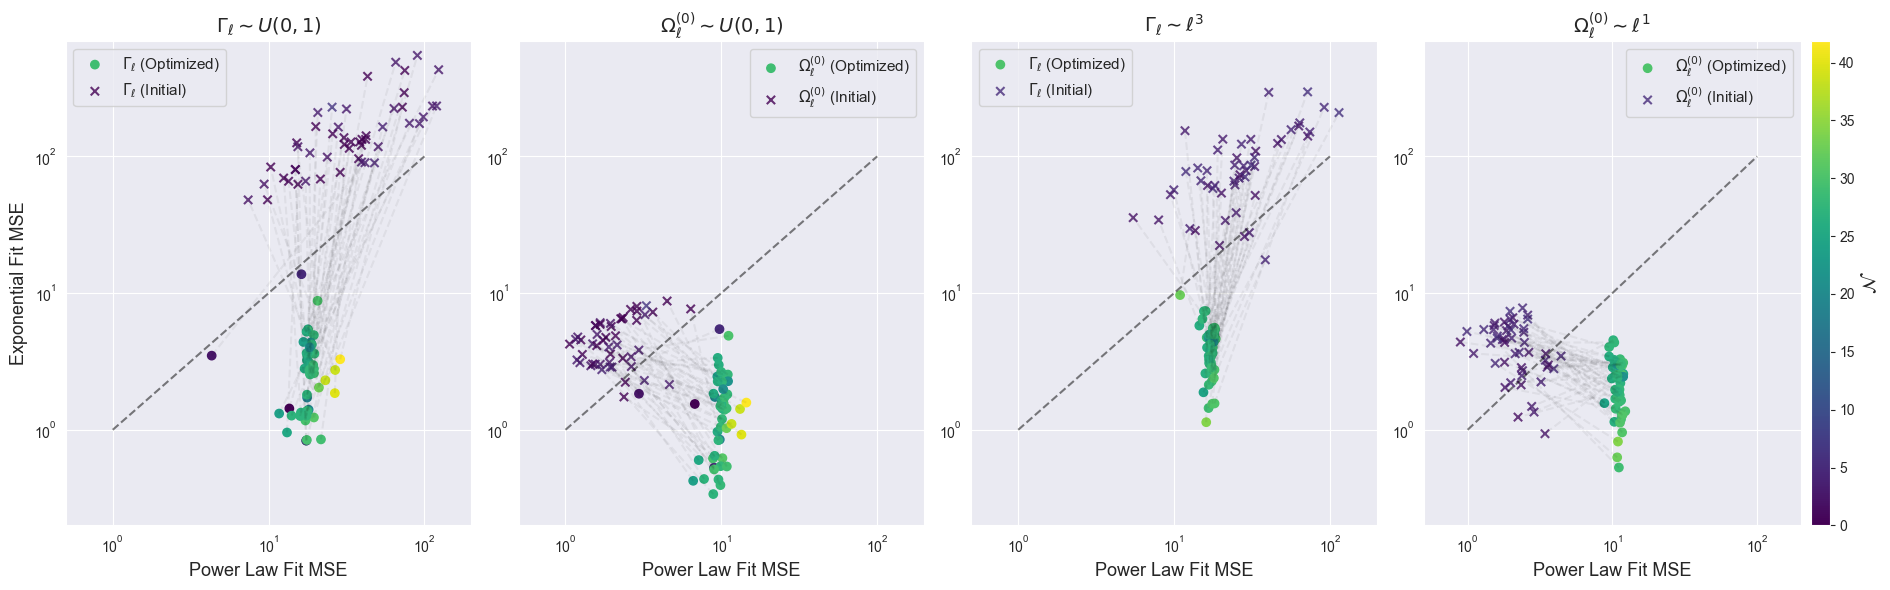

In [296]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('darkgrid')

# Load the data
fig, axs = plt.subplots(1, 4, figsize=(19, 6))

stasis_vals_epoch_0 = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/stasis_vals_epoch_0.npy')
stasis_vals_epoch_end = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/stasis_vals_epoch_end.npy')

stasis_vals_epoch_0_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/simulation_results/stasis_vals_epoch_0.npy')
stasis_vals_epoch_end_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/simulation_results/stasis_vals_epoch_end.npy')

results_dict_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/simulation_results/mape_results.npy', allow_pickle=True).item()
results_dict = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/mape_results.npy', allow_pickle=True).item()

# Combine the arrays to find the range for the colorbar
all_stasis_vals = np.concatenate([stasis_vals_epoch_0, stasis_vals_epoch_end, stasis_vals_epoch_0_pl, stasis_vals_epoch_end_pl])
vmin = np.min(all_stasis_vals)
vmax = np.max(all_stasis_vals)

# Plot the scatter points with color coding by stasis value
sc1 = axs[0].scatter(results_dict['epoch_end']['gamma']['pl'], results_dict['epoch_end']['gamma']['exp'], c=stasis_vals_epoch_end, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Gamma_\ell$ (Optimized)')
sc2 = axs[0].scatter(results_dict['epoch_0']['gamma']['pl'], results_dict['epoch_0']['gamma']['exp'], c=stasis_vals_epoch_0, cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Gamma_\ell$ (Initial)')
sc3 = axs[1].scatter(results_dict['epoch_end']['omega']['pl'], results_dict['epoch_end']['omega']['exp'], c=stasis_vals_epoch_end, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Omega_\ell^{(0)}$ (Optimized)')
sc4 = axs[1].scatter(results_dict['epoch_0']['omega']['pl'], results_dict['epoch_0']['omega']['exp'], c=stasis_vals_epoch_0, cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Omega_\ell^{(0)}$ (Initial)')
sc5 = axs[2].scatter(results_dict_pl['epoch_end']['gamma']['pl'], results_dict_pl['epoch_end']['gamma']['exp'], c=stasis_vals_epoch_end_pl, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Gamma_\ell$ (Optimized)')
sc6 = axs[2].scatter(results_dict_pl['epoch_0']['gamma']['pl'], results_dict_pl['epoch_0']['gamma']['exp'], c=stasis_vals_epoch_0_pl ,cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Gamma_\ell$ (Initial)')
sc7 = axs[3].scatter(results_dict_pl['epoch_end']['omega']['pl'], results_dict_pl['epoch_end']['omega']['exp'], c=stasis_vals_epoch_end_pl, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Omega_\ell^{(0)}$ (Optimized)')
sc8 = axs[3].scatter(results_dict_pl['epoch_0']['omega']['pl'], results_dict_pl['epoch_0']['omega']['exp'], c=stasis_vals_epoch_0_pl, cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Omega_\ell^{(0)}$ (Initial)')

for i in range(len(results_dict['epoch_end']['gamma']['pl'])):
    axs[0].plot([results_dict['epoch_end']['gamma']['pl'][i], results_dict['epoch_0']['gamma']['pl'][i]], 
             [results_dict['epoch_end']['gamma']['exp'][i], results_dict['epoch_0']['gamma']['exp'][i]], 
             color='black', alpha=0.05, ls='--')
    axs[1].plot([results_dict['epoch_end']['omega']['pl'][i], results_dict['epoch_0']['omega']['pl'][i]], 
             [results_dict['epoch_end']['omega']['exp'][i], results_dict['epoch_0']['omega']['exp'][i]], 
             color='black', alpha=0.05, ls='--')
    axs[2].plot([results_dict_pl['epoch_end']['gamma']['pl'][i], results_dict_pl['epoch_0']['gamma']['pl'][i]],
                [results_dict_pl['epoch_end']['gamma']['exp'][i], results_dict_pl['epoch_0']['gamma']['exp'][i]],
                color='black', alpha=0.05, ls='--')
    axs[3].plot([results_dict_pl['epoch_end']['omega']['pl'][i], results_dict_pl['epoch_0']['omega']['pl'][i]],
                [results_dict_pl['epoch_end']['omega']['exp'][i], results_dict_pl['epoch_0']['omega']['exp'][i]],
                color='black', alpha=0.05, ls='--')


# Plot 1:1 line
axs[0].plot([1e0, 1e2], [1e-0, 1e2], color='black', ls='--', alpha=0.5)
axs[1].plot([1e0, 1e2], [1e-0, 1e2], color='black', ls='--', alpha=0.5)
axs[2].plot([1e0, 1e2], [1e-0, 1e2], color='black', ls='--', alpha=0.5)
axs[3].plot([1e0, 1e2], [1e-0, 1e2], color='black', ls='--', alpha=0.5)

# Set logarithmic scale and limits
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[3].set_xscale('log')
axs[3].set_yscale('log')

axs[0].legend(fontsize=11)
axs[1].legend(fontsize=11)
axs[2].legend(fontsize=11)
axs[3].legend(fontsize=11)

lower_lim_y = 2e-1
upper_lim_y = 7e2
lower_lim_x = .5
upper_lim_x = 2e2
axs[0].set_xlim(lower_lim_x, upper_lim_x)
axs[0].set_ylim(lower_lim_y, upper_lim_y)
axs[1].set_xlim(lower_lim_x, upper_lim_x)
axs[1].set_ylim(lower_lim_y, upper_lim_y)
axs[2].set_xlim(lower_lim_x, upper_lim_x)
axs[2].set_ylim(lower_lim_y, upper_lim_y)
axs[3].set_xlim(lower_lim_x, upper_lim_x)
axs[3].set_ylim(lower_lim_y, upper_lim_y)

# Create a colorbar for both subplots
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(sc1, cax=cax)
cbar.set_label(r'$\mathcal{N}$', fontsize=14)

# Add labels
# fig.suptitle('Gradient Ascent MSE Comparison', fontsize=16)
axs[0].set_xlabel('Power Law Fit MSE', fontsize=13)
axs[0].set_ylabel('Exponential Fit MSE', fontsize=13)
axs[0].set_title(r'$\Gamma_\ell \sim U(0,1)$', fontsize=14)
axs[1].set_xlabel('Power Law Fit MSE', fontsize=13)
# axs[1].set_ylabel('Exponential MSE', fontsize=12)
axs[1].set_title(r'$\Omega_\ell^{(0)} \sim U(0,1)$', fontsize=14)
axs[2].set_xlabel('Power Law Fit MSE', fontsize=13)
axs[2].set_title(r'$\Gamma_\ell \sim \ell^3$', fontsize=14)
axs[3].set_xlabel('Power Law Fit MSE', fontsize=13)
axs[3].set_title(r'$\Omega_\ell^{(0)} \sim \ell^1$', fontsize=14)

# Show plot
plt.tight_layout()
# plt.show()
plt.savefig(f'{PATH}/simulation_results/combined_mape_plot.png', dpi=300)
# 

In [318]:
results_dict['epoch_0']['omega']['r2_exp'][13] = 0.9091564670300387
results_dict['epoch_0']['omega']['r2_exp'][13] = 0.9870325548237502

In [319]:
np.save('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/mape_results.npy', results_dict)

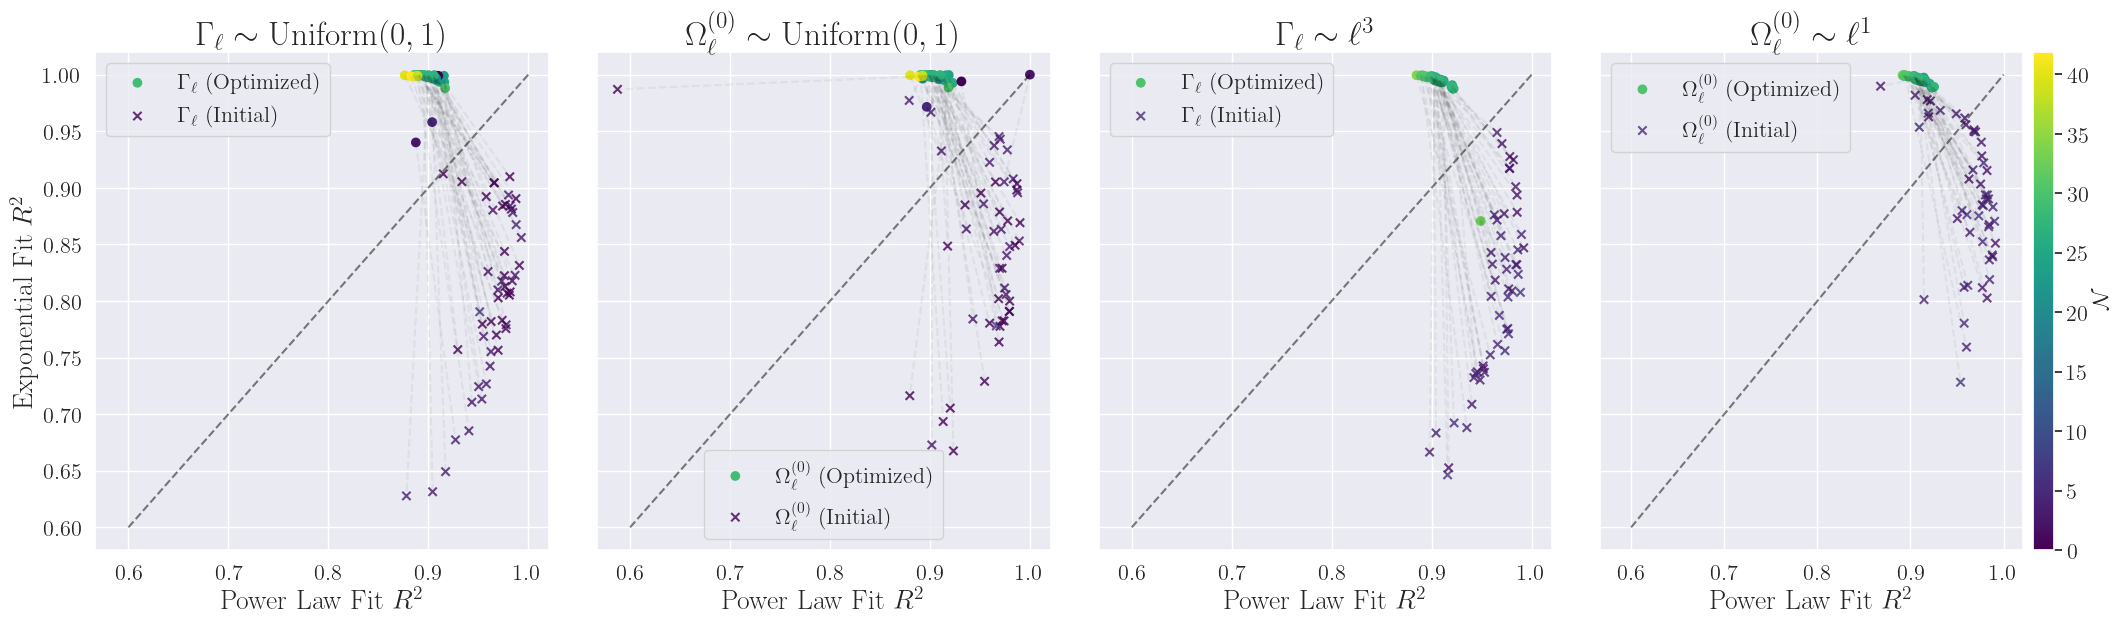

In [575]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

## make font times new roman in matplotlib
sns.set_style('darkgrid')
# plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# Load the data
fig, axs = plt.subplots(1, 4, figsize=(22, 7), sharex=True, sharey=True)

stasis_vals_epoch_0 = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/stasis_vals_epoch_0.npy')
stasis_vals_epoch_end = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/stasis_vals_epoch_end.npy')

stasis_vals_epoch_0_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/simulation_results/stasis_vals_epoch_0.npy')
stasis_vals_epoch_end_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/simulation_results/stasis_vals_epoch_end.npy')

results_dict_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/simulation_results/mape_results.npy', allow_pickle=True).item()
results_dict = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/mape_results.npy', allow_pickle=True).item()

# Combine the arrays to find the range for the colorbar
all_stasis_vals = np.concatenate([stasis_vals_epoch_0, stasis_vals_epoch_end, stasis_vals_epoch_0_pl, stasis_vals_epoch_end_pl])
vmin = np.min(all_stasis_vals)
vmax = np.max(all_stasis_vals)
# Plot the scatter points with color coding by stasis value
sc1 = axs[0].scatter(results_dict['epoch_end']['gamma']['r2_pl'], results_dict['epoch_end']['gamma']['r2_exp'], c=stasis_vals_epoch_end, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Gamma_\ell$ (Optimized)')
sc2 = axs[0].scatter(results_dict['epoch_0']['gamma']['r2_pl'], results_dict['epoch_0']['gamma']['r2_exp'], c=stasis_vals_epoch_0, cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Gamma_\ell$ (Initial)')
sc3 = axs[1].scatter(results_dict['epoch_end']['omega']['r2_pl'], results_dict['epoch_end']['omega']['r2_exp'], c=stasis_vals_epoch_end, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Omega_\ell^{(0)}$ (Optimized)')
sc4 = axs[1].scatter(results_dict['epoch_0']['omega']['r2_pl'], results_dict['epoch_0']['omega']['r2_exp'], c=stasis_vals_epoch_0, cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Omega_\ell^{(0)}$ (Initial)')
sc5 = axs[2].scatter(results_dict_pl['epoch_end']['gamma']['r2_pl'], results_dict_pl['epoch_end']['gamma']['r2_exp'], c=stasis_vals_epoch_end_pl, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Gamma_\ell$ (Optimized)')
sc6 = axs[2].scatter(results_dict_pl['epoch_0']['gamma']['r2_pl'], results_dict_pl['epoch_0']['gamma']['r2_exp'], c=stasis_vals_epoch_0_pl ,cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Gamma_\ell$ (Initial)')
sc7 = axs[3].scatter(results_dict_pl['epoch_end']['omega']['r2_pl'], results_dict_pl['epoch_end']['omega']['r2_exp'], c=stasis_vals_epoch_end_pl, cmap='viridis', vmin=vmin, vmax=vmax, marker='o', label=r'$\Omega_\ell^{(0)}$ (Optimized)')
sc8 = axs[3].scatter(results_dict_pl['epoch_0']['omega']['r2_pl'], results_dict_pl['epoch_0']['omega']['r2_exp'], c=stasis_vals_epoch_0_pl, cmap='viridis', vmin=vmin, vmax=vmax, marker='x', alpha=0.8, label=r'$\Omega_\ell^{(0)}$ (Initial)')

for i in range(len(results_dict['epoch_end']['gamma']['r2_pl'])):
    axs[0].plot([results_dict['epoch_end']['gamma']['r2_pl'][i], results_dict['epoch_0']['gamma']['r2_pl'][i]], 
             [results_dict['epoch_end']['gamma']['r2_exp'][i], results_dict['epoch_0']['gamma']['r2_exp'][i]], 
             color='black', alpha=0.05, ls='--')
    axs[1].plot([results_dict['epoch_end']['omega']['r2_pl'][i], results_dict['epoch_0']['omega']['r2_pl'][i]], 
             [results_dict['epoch_end']['omega']['r2_exp'][i], results_dict['epoch_0']['omega']['r2_exp'][i]], 
             color='black', alpha=0.05, ls='--')
    axs[2].plot([results_dict_pl['epoch_end']['gamma']['r2_pl'][i], results_dict_pl['epoch_0']['gamma']['r2_pl'][i]],
                [results_dict_pl['epoch_end']['gamma']['r2_exp'][i], results_dict_pl['epoch_0']['gamma']['r2_exp'][i]],
                color='black', alpha=0.05, ls='--')
    axs[3].plot([results_dict_pl['epoch_end']['omega']['r2_pl'][i], results_dict_pl['epoch_0']['omega']['r2_pl'][i]],
                [results_dict_pl['epoch_end']['omega']['r2_exp'][i], results_dict_pl['epoch_0']['omega']['r2_exp'][i]],
                color='black', alpha=0.05, ls='--')

# # Plot 1:1 line
axs[0].plot([0.6, 1], [0.6, 1], color='black', ls='--', alpha=0.5)
axs[1].plot([0.6, 1], [0.6, 1], color='black', ls='--', alpha=0.5)
axs[2].plot([0.6, 1], [0.6, 1], color='black', ls='--', alpha=0.5)
axs[3].plot([0.6, 1], [0.6, 1], color='black', ls='--', alpha=0.5)

# Set logarithmic scale and limits
# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[3].set_xscale('log')
# axs[3].set_yscale('log')

axs[0].legend(fontsize=16)
axs[1].legend(fontsize=16)
axs[2].legend(fontsize=16)
axs[3].legend(fontsize=16)

# Create a colorbar for both subplots
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(sc1, cax=cax)
cbar.set_label(r'$\mathcal{N}$', fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Add labels
# fig.suptitle('Gradient Ascent MSE Comparison', fontsize=16)
axs[0].set_xlabel(r'Power Law Fit $R^2$', fontsize=20)
axs[0].set_ylabel(r'Exponential Fit $R^2$', fontsize=20)
axs[0].set_title(r'$\Gamma_\ell \sim \text{Uniform}(0,1)$', fontsize=24)
axs[1].set_xlabel(r'Power Law Fit $R^2$', fontsize=20)
# axs[1].set_ylabel('Exponential MSE', fontsize=12)
axs[1].set_title(r'$\Omega_\ell^{(0)} \sim \text{Uniform}(0,1)$', fontsize=24)
axs[2].set_xlabel(r'Power Law Fit $R^2$', fontsize=20)
axs[2].set_title(r'$\Gamma_\ell \sim \ell^3$', fontsize=24)
axs[3].set_xlabel(r'Power Law Fit $R^2$', fontsize=20)
axs[3].set_title(r'$\Omega_\ell^{(0)} \sim \ell^1$', fontsize=24)

## make ticks bigger
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=16)

# Show plot
plt.tight_layout()
# plt.show()
plt.savefig(f'{PATH}/simulation_results/combined_r2_plot.png', dpi=300, bbox_inches='tight')
# 

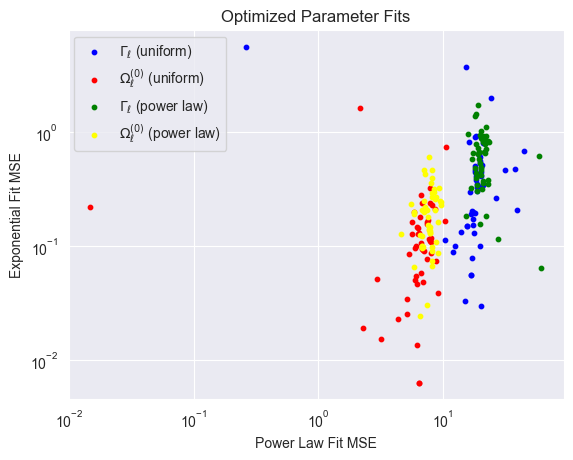

In [538]:
plt.scatter(results_dict['epoch_end']['gamma']['pl'], results_dict['epoch_end']['gamma']['exp'], color = 'blue', marker='o', label=r'$\Gamma_\ell$ (uniform)', s=10)
plt.scatter(results_dict['epoch_end']['omega']['pl'], results_dict['epoch_end']['omega']['exp'], color='red', marker='o', label=r'$\Omega_\ell^{(0)}$ (uniform)', s=10)
plt.scatter(results_dict_pl['epoch_end']['gamma']['pl'], results_dict_pl['epoch_end']['gamma']['exp'], color='green', marker='o', label=r'$\Gamma_\ell$ (power law)', s=10)
plt.scatter(results_dict_pl['epoch_end']['omega']['pl'], results_dict_pl['epoch_end']['omega']['exp'], color='yellow',marker='o', label=r'$\Omega_\ell^{(0)}$ (power law)', s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Power Law Fit MSE')
plt.ylabel('Exponential Fit MSE')
plt.title('Optimized Parameter Fits')
plt.legend()

In [518]:
print(np.round(results_dict['epoch_end']['gamma']['exp'], 5))

print(np.where(results_dict['epoch_end']['gamma']['exp'][val] > 50 for val in range(len(results_dict['epoch_end']['gamma']['exp']))))

###4, 6, 8, 19, 20, 35, 40
print(results_dict['idx'][4], results_dict['idx'][6], results_dict['idx'][8], results_dict['idx'][19], results_dict['idx'][20], results_dict['idx'][35], results_dict['idx'][40])

[3.419300e-01 3.477600e-01 1.147400e-01 9.299800e-01 9.980000e-02
 3.801000e-01 7.830000e-02 9.081400e-01 1.913000e-01 8.837000e-02
 1.536800e-01 3.061400e-01 9.043100e-01 1.959200e-01 4.702500e-01
 1.741200e-01 8.018400e-01 4.483600e-01 2.978900e-01 5.570000e-02
 5.570000e-02 6.048800e-01 8.310000e-01 2.063100e-01 2.024460e+00
 2.095300e-01 1.499300e-01 4.178600e-01 2.657400e-01 3.725550e+00
 5.055400e-01 3.324100e-01 4.159500e-01 3.505100e-01 5.344900e-01
 9.424506e+01 1.005700e-01 2.000500e-01 4.808300e-01 5.211100e-01
 3.290000e-02 1.296900e-01 5.570400e-01 5.676750e+00 4.453100e-01
 6.325300e-01 6.939400e-01 1.497400e-01 4.632800e-01 1.342000e-01]
(array([0]),)
12 14 16 26 27 40 45


In [ ]:
end_idxs_omega_pl = []
end_idxs_gamma_pl = []

In [305]:
## 4,6
import numpy as np
idx = 20
# omega_mse_exp = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/omega_mse_exp_{idx}.npy', allow_pickle=True)
# omega_mse_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/omega_mse_pl_{idx}.npy', allow_pickle=True)
# gamma_mse_exp = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/gamma_mse_exp_{idx}.npy', allow_pickle=True)
# gamma_mse_pl = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/simulation_results/gamma_mse_pl_{idx}.npy', allow_pickle=True)
omega_vals = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/omega_vals_gradient_ascent_uniform_{idx}.npy', allow_pickle=True)
gamma_vals = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/gamma_vals_gradient_ascent_uniform_{idx}.npy', allow_pickle=True)

In [306]:
first_omega, last_omega = omega_vals[0], omega_vals[-1]
first_gamma, last_gamma = gamma_vals[0], gamma_vals[-1]

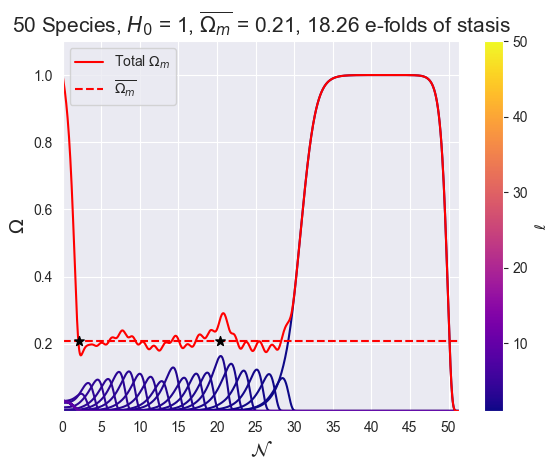

In [307]:
sim = Simulator(Omega_0=last_omega, Gamma_0=last_gamma)
sim.return_stasis()
sim.plot_abundance()

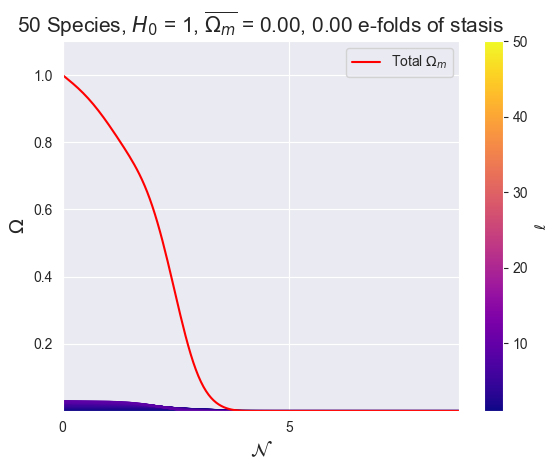

In [308]:
sim = Simulator(Omega_0=first_omega, Gamma_0=first_omega)
sim.return_stasis()
sim.plot_abundance()

18 16


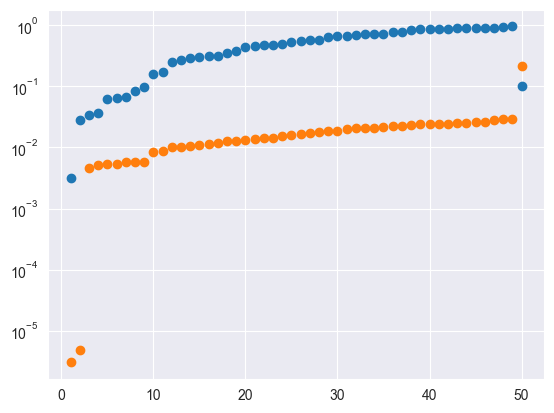

In [315]:
import matplotlib.pyplot as plt
ell = np.linspace(1, 50, 50)
plt.scatter(ell, first_gamma, label='Last Gamma')
plt.scatter(ell, first_omega, label='Last Omega')
plt.yscale('log')

print(find_end_idx(last_gamma), find_end_idx(last_omega))


[0.00457673 0.00521851 0.00539542 0.00539715 0.00573478 0.00582682
 0.0058712  0.00853014 0.00870957 0.01021572 0.01035715 0.01073288
 0.01086769 0.01157143 0.01184774 0.01265102 0.01296428 0.0130604
 0.01374154 0.01428165 0.01447445 0.01544759 0.01618472 0.01689421
 0.01758564 0.0177057  0.01829199 0.01858612 0.0202437  0.02050192
 0.0207388  0.02115216 0.02138241 0.02214358 0.02279444 0.02348458
 0.02406005 0.02421595 0.02455012 0.02461006 0.02514118 0.02561662
 0.02594836 0.02605969 0.02858614 0.0288923  0.02938781]
0.9091564670300387 0.9870325548237502
0.9154384610134179 0.09255321814403972


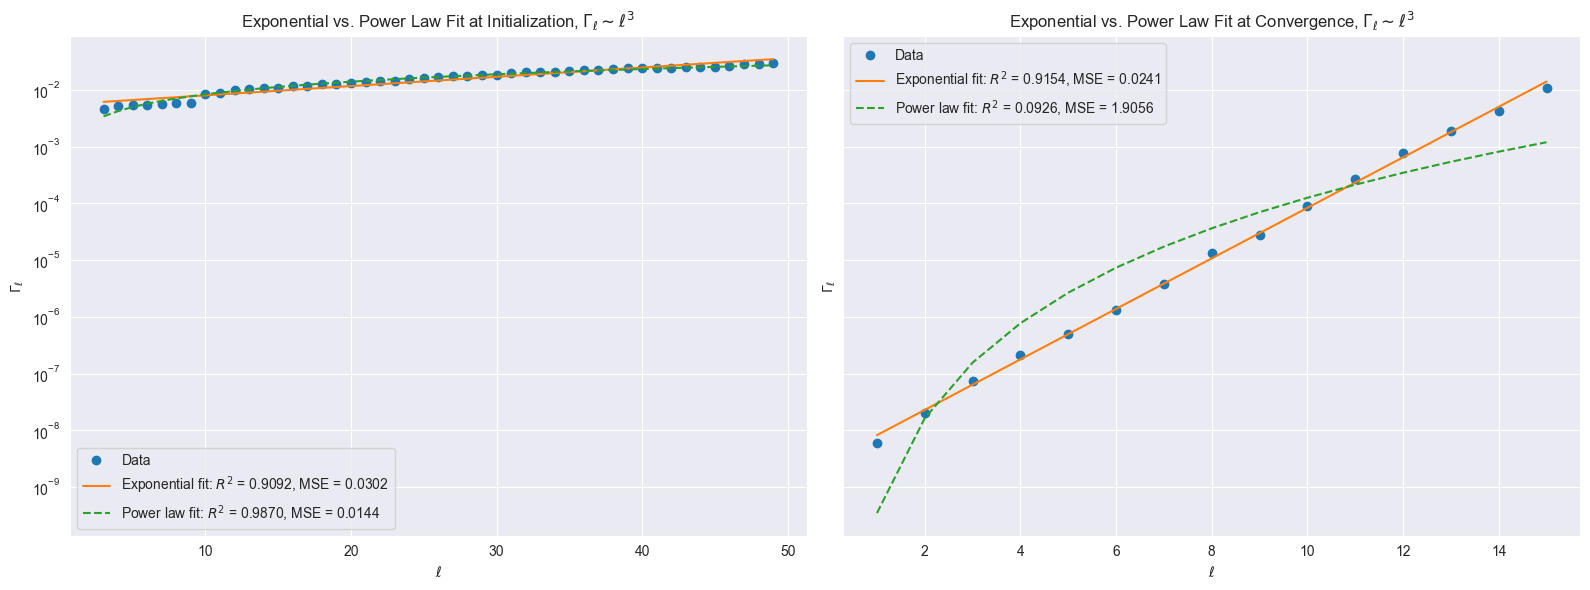

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ell = np.linspace(1, 50, 50)
y_data = first_omega[2:49]
x_data = ell[2:49]

print(y_data)

# Define the exponential function
def exponential_func(x, a, b):
    return a * x + b

# Define the power law function
def power_law_func(x, a, b):
    return a * x + b

# Fit the data to the exponential model
exp_params, exp_cov = curve_fit(exponential_func, x_data, np.log(y_data), p0=(1, 0.1), maxfev=10000)
y_exp_fit = exponential_func(x_data, *exp_params)

# Fit the data to the power law model
pow_params, pow_cov = curve_fit(power_law_func, np.log(x_data), np.log(y_data), p0=(1, 1), maxfev=10000)
y_pow_fit = power_law_func(np.log(x_data), *pow_params)

# Calculate R^2 for both fits
r2_exp = r2_score(y_data, np.exp(y_exp_fit))
r2_pow = r2_score(y_data, np.exp(y_pow_fit))

print(r2_exp, r2_pow)

mse_exp = np.mean((np.log(y_data) - y_exp_fit) ** 2)
mse_pow = np.mean((np.log(y_data) - y_pow_fit) ** 2)

weights = 1 / (y_data + 1e-10)
mse_exp = np.average((np.log(y_data) - y_exp_fit) ** 2, weights=weights)
mse_pow = np.average((np.log(y_data) - y_pow_fit) ** 2, weights=weights)
mape_pl = np.mean(np.abs((np.log(y_data) - y_pow_fit) / np.log(y_data + 1e-10))) * 100   
mape_exp = np.mean(np.abs((np.log(y_data) - y_exp_fit) / np.log(y_data + 1e-10))) * 100
# print(mape_pl, mape_exp)

# Plot the results
# plt.figure(figsize=(10, 6))
axs[0].plot(x_data, y_data, 'o', label='Data')
axs[0].plot(x_data, np.exp(y_exp_fit), '-', label=f'Exponential fit: $R^2$ = {r2_exp:.4f}, MSE = {mse_exp:.4f}')
axs[0].plot(x_data, np.exp(y_pow_fit), '--', label=f'Power law fit: $R^2$ = {r2_pow:.4f}, MSE = {mse_pow:.4f}')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$\Gamma_\ell$')
axs[0].legend()
axs[0].set_title(r'Exponential vs. Power Law Fit at Initialization, $\Gamma_\ell \sim \ell^3$')

end_idx = find_end_idx(last_gamma)
y_data = last_omega[3:end_idx]
x_data = np.linspace(1, y_data.size, y_data.size)

# Define the exponential function
def exponential_func(x, a, b):
    return a * x + b

# Define the power law function
def power_law_func(x, a, b):
    return a * x + b

# Fit the data to the exponential model
exp_params, exp_cov = curve_fit(exponential_func, x_data, np.log(y_data), p0=(1, 0.1), maxfev=10000)
y_exp_fit = exponential_func(x_data, *exp_params)

# Fit the data to the power law model
pow_params, pow_cov = curve_fit(power_law_func, np.log(x_data), np.log(y_data), p0=(1, 1), maxfev=10000)
y_pow_fit = power_law_func(np.log(x_data), *pow_params)

# Calculate R^2 for both fits
r2_exp = r2_score(y_data, np.exp(y_exp_fit))
r2_pow = r2_score(y_data, np.exp(y_pow_fit))

print(r2_exp, r2_pow)

mse_exp = np.mean((np.log(y_data) - y_exp_fit) ** 2)
mse_pow = np.mean((np.log(y_data) - y_pow_fit) ** 2)

weights = 1 / (y_data + 1e-2)
mse_exp = np.average((np.log(y_data) - y_exp_fit) ** 2, weights=weights)
mse_pow = np.average((np.log(y_data) - y_pow_fit) ** 2, weights=weights)

mape_pl = np.mean(np.abs((np.log(y_data) - y_pow_fit) / np.log(y_data + 1e-10))) * 100   
mape_exp = np.mean(np.abs((np.log(y_data) - y_exp_fit) / np.log(y_data + 1e-10))) * 100
# print(mape_pl, mape_exp)

# Plot the results
# plt.figure(figsize=(10, 6))
axs[1].plot(x_data, y_data, 'o', label='Data')
axs[1].plot(x_data, np.exp(y_exp_fit), '-', label=f'Exponential fit: $R^2$ = {r2_exp:.4f}, MSE = {mse_exp:.4f}')
axs[1].plot(x_data, np.exp(y_pow_fit), '--', label=f'Power law fit: $R^2$ = {r2_pow:.4f}, MSE = {mse_pow:.4f}')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\ell$')
axs[1].set_ylabel(r'$\Gamma_\ell$')
axs[1].set_title(r'Exponential vs. Power Law Fit at Convergence, $\Gamma_\ell \sim \ell^3$')
axs[1].legend()
plt.tight_layout()
# plt.show()
# plt.show()



In [271]:
results_dict['epoch_end']['omega']['pl'][-7] = 2.9613472949599533
results_dict['epoch_end']['omega']['exp'][-7] = 1.8355818333196476

In [256]:
results_dict['epoch_0']['gamma']['pl'][36] = 41.944715997438166
results_dict['epoch_0']['gamma']['exp'][36] = 133.18573996666046

0.049917381363343866 2.466624968782245


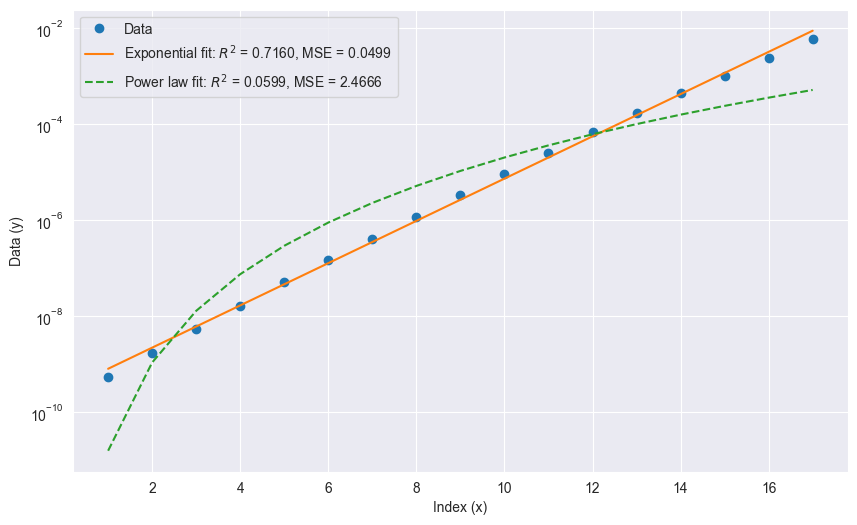

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

end_idx = find_end_idx(last_gamma) - 2
y_data = last_omega[1:end_idx]
x_data = np.linspace(1, y_data.size, y_data.size)

# Define the exponential function
def exponential_func(x, a, b):
    return a * x + b

# Define the power law function
def power_law_func(x, a, b):
    return a * x + b

# Fit the data to the exponential model
exp_params, exp_cov = curve_fit(exponential_func, x_data, np.log(y_data), p0=(1, 0.1), maxfev=10000)
y_exp_fit = exponential_func(x_data, *exp_params)

# Fit the data to the power law model
pow_params, pow_cov = curve_fit(power_law_func, np.log(x_data), np.log(y_data), p0=(1, 1), maxfev=10000)
y_pow_fit = power_law_func(np.log(x_data), *pow_params)

# Calculate R^2 for both fits
r2_exp = r2_score(y_data, np.exp(y_exp_fit))
r2_pow = r2_score(y_data, np.exp(y_pow_fit))

mse_exp = np.mean((np.log(y_data) - y_exp_fit) ** 2)
mse_pow = np.mean((np.log(y_data) - y_pow_fit) ** 2)

print(mse_exp, mse_pow)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o', label='Data')
plt.plot(x_data, np.exp(y_exp_fit), '-', label=f'Exponential fit: $R^2$ = {r2_exp:.4f}, MSE = {mse_exp:.4f}')
plt.plot(x_data, np.exp(y_pow_fit), '--', label=f'Power law fit: $R^2$ = {r2_pow:.4f}, MSE = {mse_pow:.4f}')
plt.yscale('log')
plt.xlabel('Index (x)')
plt.ylabel('Data (y)')
plt.legend()
plt.show()

In [328]:
gamma = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/gamma_vals_gradient_ascent_uniform_0.npy')
omega = np.load('/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_results/omega_vals_gradient_ascent_uniform_0.npy')

In [325]:
print(len(gamma), len(omega))

8287 8287


In [359]:
omega = np.load('/Users/snehpandya/Projects/stasis/unsorted_omega_gif/omega_trajectories_35k.npy')
gamma = np.load('/Users/snehpandya/Projects/stasis/unsorted_omega_gif/gamma_trajectories_35k.npy')

66.92718884184478


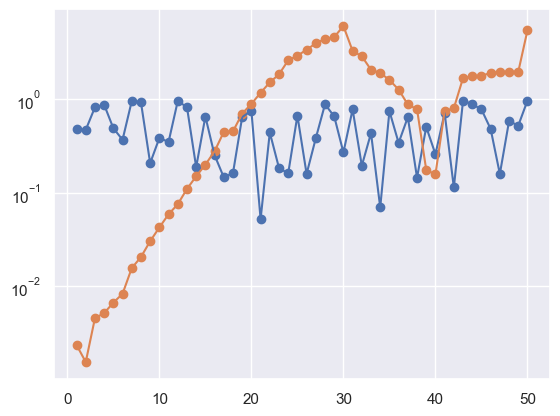

In [381]:
sim = Simulator(Omega_0 = 10**(omega[-1]), Gamma_0 = 10**(gamma[-1]))
sim.return_stasis()
sim1 = Simulator(Omega_0 = 10**(omega[0]), Gamma_0 = 10**(gamma[0]))
sim1.return_stasis()
ell = np.linspace(1, 50, 50)
rand_omegas = np.random.permutation(10**(omega[0]))
plt.scatter(ell, rand_omegas)
plt.plot(ell, rand_omegas)
plt.scatter(ell, 10**(omega[-1]))
plt.plot(ell, 10**(omega[-1]))
print(np.max(sim.Gamma_0))
plt.yscale('log')

In [329]:
red_curves_uniform = []
t_efolds_uniform = []
from tqdm import tqdm
for i in tqdm(range(0, len(omega), 100)):
    sim = Simulator(Omega_0 = omega[i], Gamma_0 = gamma[i])
    sim.return_stasis()
    red_curves_uniform.append(sim.total_abundance)
    t_efolds_uniform.append(sim.t_efolds)

100%|██████████| 83/83 [01:31<00:00,  1.11s/it]


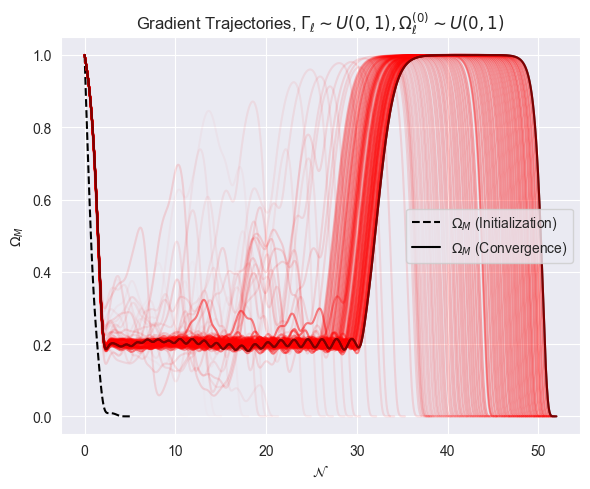

In [622]:
plt.figure(figsize=(6, 5))
for i, curve in enumerate(red_curves_uniform ):
    if i == 0:
        plt.plot(t_efolds_uniform [i], curve, color='black', alpha=1, ls = '--', label = r'$\Omega_M$ (Initialization)')
    if i == len(red_curves_uniform ) - 1:
        plt.plot(t_efolds_uniform [i], curve, color='black', alpha=1, label = r'$\Omega_M$ (Convergence)')
    plt.plot(t_efolds_uniform [i], curve, color='red', alpha=(0.5 * i) / len(red_curves_uniform ))
plt.legend()
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$\Omega_M$')
plt.title(r'Gradient Trajectories, $\Gamma_\ell \sim U(0,1), \Omega_\ell^{(0)} \sim U(0,1) $')
plt.tight_layout()

In [339]:
omega = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/omega_vals_gradient_ascent_pl_35.npy', allow_pickle=True)
gamma = np.load(f'/Users/snehpandya/Projects/stasis/paper_plot_data/power_law_results/gamma_vals_gradient_ascent_pl_35.npy', allow_pickle=True)

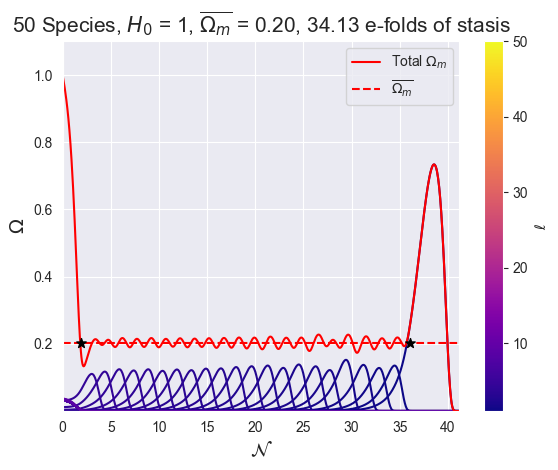

In [340]:
sim = Simulator(Omega_0 = omega[-1], Gamma_0 = gamma[-1])
sim.return_stasis()
sim.plot_abundance()

In [341]:
print(len(gamma), len(omega))

29805 29805


In [342]:
red_curves_pl = []
t_efolds_pl = []
from tqdm import tqdm
for i in tqdm(range(0, len(omega), 350)):
    sim = Simulator(Omega_0 = omega[i], Gamma_0 = gamma[i])
    sim.return_stasis()
    red_curves_pl.append(sim.total_abundance)
    t_efolds_pl.append(sim.t_efolds)

100%|██████████| 86/86 [01:26<00:00,  1.01s/it]


In [345]:
pl_trajs = {'red_curves_pl': red_curves_pl, 't_efolds_pl': t_efolds_pl}
np.save(f'/Users/snehpandya/Projects/stasis/paper_plot_data/pl_trajs.npy', pl_trajs)
uniform_trajs = {'red_curves_uniform': red_curves_uniform, 't_efolds_uniform': t_efolds_uniform}
np.save(f'/Users/snehpandya/Projects/stasis/paper_plot_data/uniform_trajs.npy', uniform_trajs)

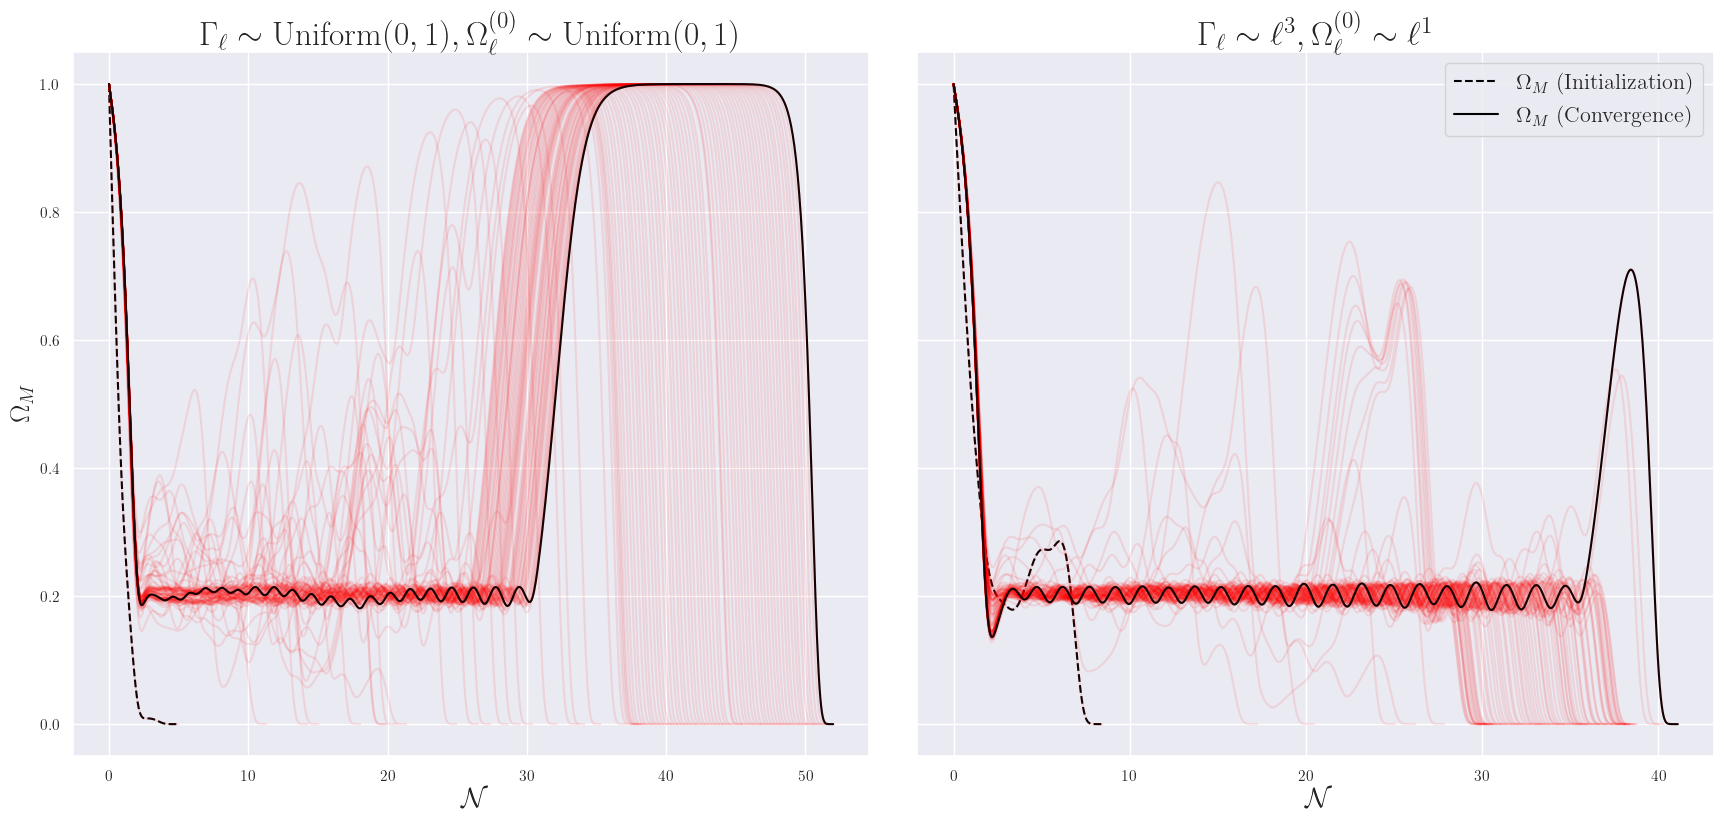

In [574]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})



for i, curve in enumerate(red_curves_uniform):
    if i == 0:
        axs[0].plot(t_efolds_uniform [i], curve, color='black', alpha=1, ls = '--', label = r'$\Omega_M$ (Initialization)')
    if i == len(red_curves_uniform ) - 1:
        axs[0].plot(t_efolds_uniform [i], curve, color='black', alpha=1, label = r'$\Omega_M$ (Convergence)')
    axs[0].plot(t_efolds_uniform [i], curve, color='red', alpha=0.1)
# axs[0].legend()
axs[0].set_xlabel(r'$\mathcal{N}$', fontsize=20)
axs[0].set_ylabel(r'$\Omega_M$', fontsize=20)
axs[0].set_title(r'$\Gamma_\ell \sim \text{Uniform}(0,1), \Omega_\ell^{(0)} \sim \text{Uniform}(0,1) $', fontsize=24)

for i, curve in enumerate(red_curves_pl):
    if i == 0:
        axs[1].plot(t_efolds_pl[i], curve, color='black', alpha=1, ls = '--', label = r'$\Omega_M$ (Initialization)')
    if i == len(red_curves_pl) - 1:
        axs[1].plot(t_efolds_pl[i], curve, color='black', alpha=1, label = r'$\Omega_M$ (Convergence)')
    axs[1].plot(t_efolds_pl[i], curve, color='red', alpha=0.1)
axs[1].legend(fontsize=16)
axs[1].set_xlabel(r'$\mathcal{N}$', fontsize=20)
# axs[1].set_ylabel(r'$\Omega_M$')
axs[1].set_title(r'$\Gamma_\ell \sim \ell^3, \Omega_\ell^{(0)} \sim \ell^1 $', fontsize=24)
plt.tight_layout()
plt.savefig('/Users/snehpandya/Projects/stasis/paper_plot_data/gradient_trajectories/gradient_trajs.png', dpi = 300, bbox_inches='tight')


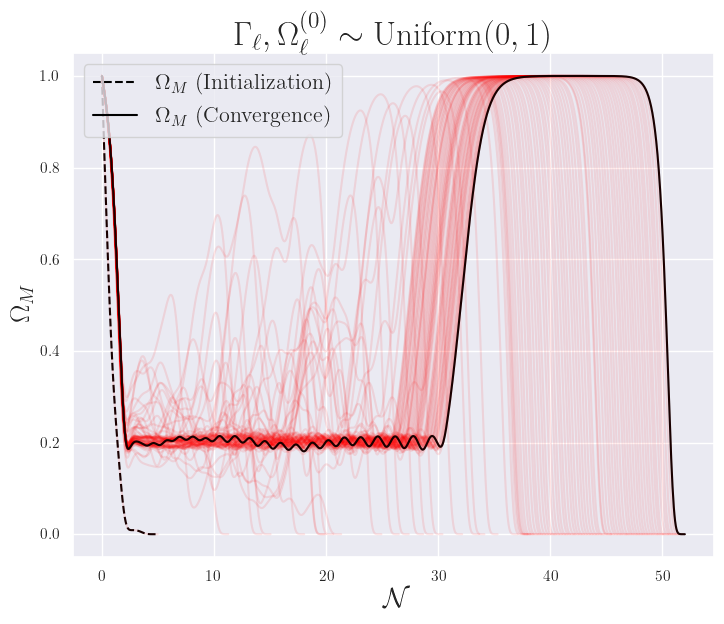

In [590]:
plt.figure(figsize=(8, 7))

for i, curve in enumerate(red_curves_uniform):
    if i == 0:
        plt.plot(t_efolds_uniform [i], curve, color='black', alpha=1, ls = '--', label = r'$\Omega_M$ (Initialization)')
    if i == len(red_curves_uniform ) - 1:
        plt.plot(t_efolds_uniform [i], curve, color='black', alpha=1, label = r'$\Omega_M$ (Convergence)')
    plt.plot(t_efolds_uniform [i], curve, color='red', alpha=0.1)
# axs[0].legend()
plt.xlabel(r'$\mathcal{N}$', fontsize=20)
plt.ylabel(r'$\Omega_M$', fontsize=20)
plt.title(r'$\Gamma_\ell, \Omega_\ell^{(0)} \sim \text{Uniform}(0,1) $', fontsize=24)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig('/Users/snehpandya/Projects/stasis/paper_plot_data/gradient_trajectories/gradient_traj_uniform.png', dpi = 300, bbox_inches='tight')


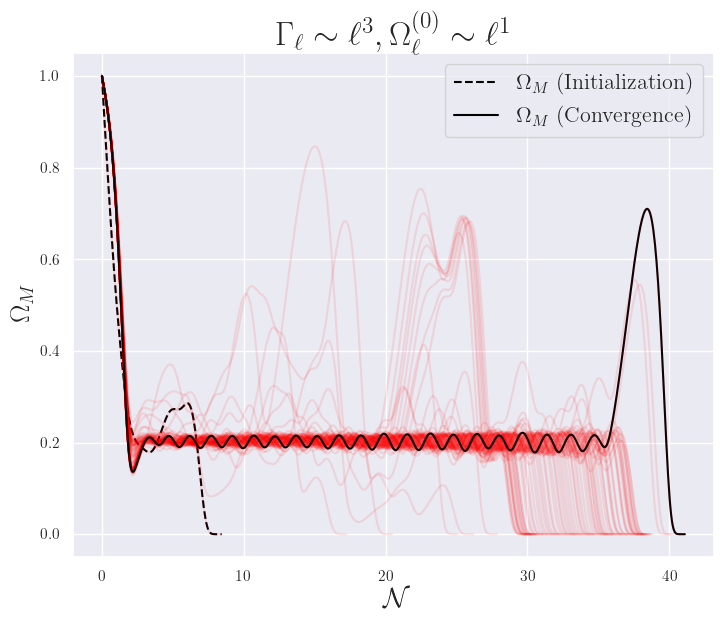

In [592]:
plt.figure(figsize=(8, 7))

for i, curve in enumerate(red_curves_pl):
    if i == 0:
        plt.plot(t_efolds_pl[i], curve, color='black', alpha=1, ls = '--', label = r'$\Omega_M$ (Initialization)')
    if i == len(red_curves_pl) - 1:
        plt.plot(t_efolds_pl[i], curve, color='black', alpha=1, label = r'$\Omega_M$ (Convergence)')
    plt.plot(t_efolds_pl[i], curve, color='red', alpha=0.1)
# axs[0].legend()
plt.xlabel(r'$\mathcal{N}$', fontsize=20)
plt.ylabel(r'$\Omega_M$', fontsize=20)
plt.title(r'$\Gamma_\ell \sim \ell^3, \Omega_\ell^{(0)} \sim \ell^1 $', fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/snehpandya/Projects/stasis/paper_plot_data/gradient_trajectories/gradient_traj_pl.png', dpi = 300, bbox_inches='tight')


In [422]:
gamma = np.load('/Users/snehpandya/Projects/stasis/src/scripts/gamma_trajectories_50k_sorted.npy')
omega = np.load('/Users/snehpandya/Projects/stasis/src/scripts/omega_trajectories_50k_sorted.npy')

In [423]:
gamma.shape

(50000, 50)

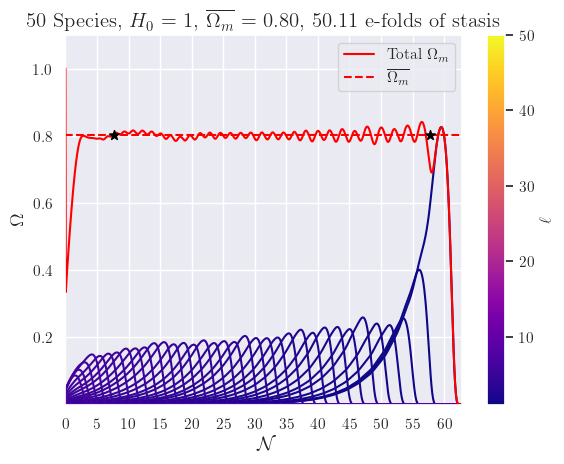

In [425]:
sim = Simulator(Omega_0 = 10**(omega[-1]), Gamma_0 = 10**(gamma[-1]))
sim.return_stasis()
sim.plot_abundance()

In [556]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Configure Matplotlib to use LaTeX
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Add more packages if needed
plt.rcParams['font.size'] = 32

# Load the existing PNG image
image = Image.open("/Users/snehpandya/Dropbox/stasis-training/2x1_gif/test.png")
image_width, image_height = image.size
dpi = 300  # Set a high DPI for better quality

# Configure Matplotlib to use LaTeX
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['font.size'] = 32  # Set font size as required

# Create a figure for rendering the LaTeX text
fig, ax = plt.subplots(figsize=(image_width / dpi, image_height / dpi), dpi=dpi)
fig.patch.set_alpha(0)  # Make the background of the figure transparent
ax.axis('off')

# Render the LaTeX text
ax.text(0.28, -.2, r'$\mathcal{N}$', ha='center', va='top', transform=ax.transAxes, fontsize=16)
ax.text(1.0, -.2, r'$\ell$', ha='center', va='top', transform=ax.transAxes, fontsize=18)
ax.text(0.03, 0.36, r'$\Omega$', ha='right', va='center', rotation='vertical', transform=ax.transAxes, fontsize=18)
ax.text(0.66, 0.36, r'$\log(\Omega_\ell^{(0)})$', ha='right', va='center', rotation='vertical', transform=ax.transAxes, fontsize=18)
ax.text(0.60, 0.39, r'$\ell$', ha='right', va='center', rotation='vertical', transform=ax.transAxes, fontsize=12)

# Save the rendered text as a temporary PNG file
fig.savefig('/Users/snehpandya/Dropbox/stasis-training/2x1_gif/temp_labels.png', bbox_inches='tight', pad_inches=.05, transparent=True)
plt.close(fig)

# Load the rendered text image
labels_image = Image.open('/Users/snehpandya/Dropbox/stasis-training/2x1_gif/temp_labels.png')

# Overlay the text image on the original image
image.paste(labels_image, (0, 0), labels_image)

image.show()

# Save the modified image
image.save("/Users/snehpandya/Dropbox/stasis-training/2x1_gif/test_modified.png", dpi=(300, 300))
